<a href="https://colab.research.google.com/github/dearsanshui/data_exploration/blob/main/SMS_Spam_Classificaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is trying to develop Neural Networks for SMS message spam classification.

Table of contents:
*   Exploratory Data Analysis
*   Text Preprocessing
*   Tokenization
*   Model Training & Selection
*   Model Evaluation
*   Discussion
*   Summary
*   References













Data will be stored in Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
%cd /content/gdrive/My Drive/kaggle/datasets

/content/gdrive/My Drive/kaggle/datasets


**Download SMS data from Kaggle.**<br> 
*If the data is already in your google drive, there is **no** need to run below code cell.*

In [ ]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset
!unzip sms-spam-collection-dataset.zip

**Data Downloaded!**

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string

# Exploratory Data Analysis

In [4]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.groupby('v1').describe()

v2         ... Unnamed: 4     
     count unique  ...        top freq
v1                 ...                
ham   4825   4516  ...    GNT:-)"    2
spam   747    653  ...        NaN  NaN

[2 rows x 16 columns]

As we can see, there are 5572 items in the dataset, 4825 ham and 747 spam.<br>
Five columns are presented, first column '**v1**' is the label, second column '**v2**' represents the text, and three other columns ['**Unnamed: 2**', '**Unnamed: 3**', '**Unnamed: 4**'] that filled with NaN. <br>
Since we only need the text and label of each SMS, we will drop the other three columns.<br>
And we will rename the first two columns as ['txtlabel', 'text'], then transform label into 1(spam) and 0(ham) by adding a new column 'label'. 

In [7]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True, axis=1)
df.columns = ['txtlabel', 'text']
df['label'] = df.txtlabel.map({'ham':0, 'spam':1})
df.head()

,txtlabel,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Message Number')

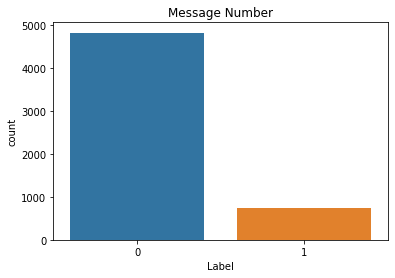

In [8]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Message Number')

## Text Preprocessing

We will remove stop words from each text since they do not contribute much to the meaning of the text.
As the SMS messages are similar to Twitter messages, we are going to use the TweetTokenizer() provided by nltk to split a text into words.

In [9]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
STOPWORDS = stopwords.words('english') + list(string.punctuation) + ['...', '..', 'u']
tknzr = TweetTokenizer()

# add a new column 'cleaned_text' to hold text after removing stop words
df["cleaned_text"] = df["text"].apply(lambda text: ' '.join([word for word in tknzr.tokenize(text.lower()) if word not in STOPWORDS]))
df.head()

,txtlabel,text,label,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think goes usf lives around though


In [11]:
print('\033[1m' + 'Original Text: ' + '\033[0m' + df.iloc[0][1])
print('\033[1m' + 'Cleaned Text: ' + '\033[0m' + df.iloc[0][3])

Original Text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned Text: go jurong point crazy available bugis n great world la e buffet cine got amore wat


# Tokenization

We are going to tokenize the word, put in an easy way, the words will be transformed into numbers.


First, let's split the data into train/validation/test set.


*   train set: train models
*   validation set: tune models and select a model
*   test set: evaluate the model

If we only have train set and test set, using train set to train several models and employing test set to select the optimal model, then evaluating the model on the test set. There could be a problem that we are likely to choose a model that already fit into the test set, and evaludating the model's performance on the same test set might not fairly reflect the model's generalizability on new examples that it has never seen before.

An explanination could be found on Prof. Andrew Ng's MOOC [Machine Learning](https://www.coursera.org/learn/machine-learning/lecture/QGKbr/model-selection-and-train-validation-test-sets)

In [12]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 1 - train_ratio - validation_ratio

train, validation, test = np.split(df.sample(frac=1, random_state=42), [int(train_ratio*len(df)), int((train_ratio + validation_ratio)*len(df))])
print("Train set size: {} ".format(len(train)))
print("Validation set size: {}".format(len(validation)))
print("Test set size: {}".format(len(test)))

train.head()

Train set size: 3900 
Validation set size: 836
Test set size: 836


,txtlabel,text,label,cleaned_text
3245,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t...",0,funny fact nobody teaches volcanoes 2 erupt ts...
944,ham,I sent my scores to sophas and i had to do sec...,0,sent scores sophas secondary application schoo...
1044,spam,We know someone who you know that fancies you....,1,know someone know fancies call 09058097218 fin...
2484,ham,Only if you promise your getting out as SOON a...,0,promise getting soon text morning let know mad...
812,spam,Congratulations ur awarded either å£500 of CD ...,1,congratulations ur awarded either å £ 500 cd g...


We will build a vocabulary with size of 10000, however, the acutal size could be smaller.

In [13]:
vocab_size = 10000
embedding_dim = 100
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [14]:
def pad_seq(tokenizer, sentenses, maxlen=100, padding='post', truncating='post'):
  """
    tokenize the sentenses into sequences, then pad the sequences to specified length

    Arguments:
    tokenizer -- Tokenizer object
    sentences -- text collection needs to be tokenized
    max_len -- maximum length of all sequences.
    padding --  String, 'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.
    truncating -- String, 'pre' or 'post' (optional, defaults to 'pre'): remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.

    Returns:
    np.array(padded) -- padded seqences in numpy arrays 
  """
  sequences = tokenizer.texts_to_sequences(sentenses)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return np.array(padded)

In [15]:
def tokenize(train, validation, test, vocab_size, oov_tok, token_scope, token_on, label_on):
  """
    Build a model with architure: embedding -> bidirectional LSTM -> Dense -> Dense(binary)

    Arguments:
    train -- train set
    validation -- validation set
    test -- test set
    vocab_size --  vocabulary size 
    oov_tok -- symbol represents out-of-vocabulary words
    token_scope -- 'all' to build vocabulary on text with the whole dataset; 'train' only on train set
    label_on -- the column name that the label resides

    Returns:
    model -- a sequence model with specified layers
  """
  tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
  if token_scope == 'all':
    tokenizer.fit_on_texts(pd.concat([train, validation, test])[token_on])
  elif token_scope == 'train':
    tokenizer.fit_on_texts(train[token_on])
  else:
    return None 

  word_index = tokenizer.word_index

  X_train = pad_seq(tokenizer, train[token_on])
  y_train = np.array(train[label_on])

  X_validation = pad_seq(tokenizer, validation[token_on])
  y_validation = np.array(validation[label_on])

  X_test = pad_seq(tokenizer, test[token_on])
  y_test = np.array(test[label_on])

  return (X_train, y_train, X_validation, y_validation, X_test, y_test, word_index)

In [16]:
(X_train, y_train, X_validation, y_validation, X_test, y_test, word_index) = \
  tokenize(train, validation, test, vocab_size, oov_tok, 'all', 'cleaned_text', 'label')

In [17]:
vocab_size = len(word_index)
print("The acutal vocabulary size: {}".format(len(word_index)))
print(len(X_train), len(y_train))
print(len(X_validation), len(y_validation))
print(len(X_test), len(y_test))
print(X_train[1:3])

The acutal vocabulary size: 8705
3900 3900
836 836
836 836
[[ 114 2859 4285 4286 2860 2861   52  526 4287 1815  279  104  118 1379
  4288  372   26  899 1380  977    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  13  139   13 2202    2 4289   93  221  176 2862   89    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

Even though we set vocabulary size to 10000, the actual vocabulary size is 8705.

# Model Training & Selection

In [18]:
num_epochs = 10

def plot_graphs(history, string):
  """
    Paint accuracy and loss line graphs

    Arguments:
    history -- a record of training loss values and metrics values at successive epochs returned by the model
    string -- axis label
  """
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

First, we will create a model presented in [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/text/text_classification_rnn): embedding -> bidirectional LSTM -> Dense -> Dense(binary)

In [19]:
def model_biLstm(vocab_size, embedding_dim, max_length):
  """
    Build a model with architure: embedding -> bidirectional LSTM -> Dense -> Dense(binary)

    Arguments:
    vocab_size -- vocab_size to train word embedding
    embedding_dim -- word embedding dimension
    max_length -- the max length of input text

    Returns:
    model -- a sequence model with specified layers
  """
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
  return model

We are going to create a second model following architeture from [Tensorflow Developer MOOC on Coursera](https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/NFvFd/going-back-to-the-imdb-dataset): embedding -> Conv1D -> MaxPooling1D -> LSTM -> Dense(binary), while using dropout to reduce overfitting.

In [20]:
def model_ConvLstm(vocab_size, embedding_dim, max_length):
  """
    Build a model with architure: embedding -> Conv1D -> MaxPooling1D -> LSTM -> Dense(binary)
    
    Arguments:
    vocab_size -- vocab_size to train word embedding
    embedding_dim -- word embedding dimension
    max_length -- the max length of input text

    Returns:
    model -- a sequence model with specified layers
  """
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv1D(64, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=4),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
  return model

Epoch 1/10
122/122 - 7s - loss: 0.1830 - accuracy: 0.9392 - val_loss: 0.0502 - val_accuracy: 0.9856
Epoch 2/10
122/122 - 6s - loss: 0.0217 - accuracy: 0.9941 - val_loss: 0.0497 - val_accuracy: 0.9856
Epoch 3/10
122/122 - 6s - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.0681 - val_accuracy: 0.9809
Epoch 4/10
122/122 - 6s - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0661 - val_accuracy: 0.9856
Epoch 5/10
122/122 - 6s - loss: 7.4516e-04 - accuracy: 0.9997 - val_loss: 0.0725 - val_accuracy: 0.9844
Epoch 6/10
122/122 - 6s - loss: 2.3837e-04 - accuracy: 1.0000 - val_loss: 0.0785 - val_accuracy: 0.9844
Epoch 7/10
122/122 - 6s - loss: 1.1858e-04 - accuracy: 1.0000 - val_loss: 0.0827 - val_accuracy: 0.9844
Epoch 8/10
122/122 - 6s - loss: 6.5990e-05 - accuracy: 1.0000 - val_loss: 0.0862 - val_accuracy: 0.9844
Epoch 9/10
122/122 - 6s - loss: 4.3686e-05 - accuracy: 1.0000 - val_loss: 0.0891 - val_accuracy: 0.9844
Epoch 10/10
122/122 - 6s - loss: 3.0883e-05 - accuracy: 1.0000 - val_loss: 0.091

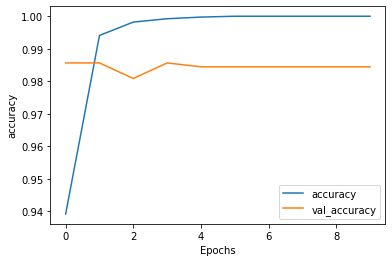

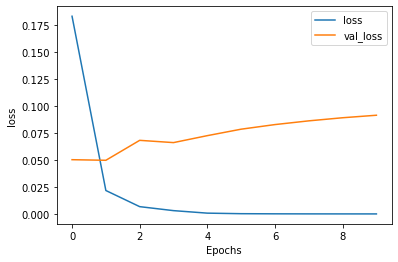

In [21]:
model_1 = model_biLstm(vocab_size, embedding_dim, max_length)
model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

tf.keras.backend.clear_session()

history_1 = model_1.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_validation, y_validation), verbose=2)
print("Model 1 Training Complete")

plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          870600    
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 935,753
Trainable params: 935,753
Non-trainable params: 0
__________________________________________________

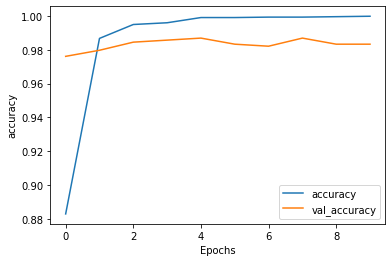

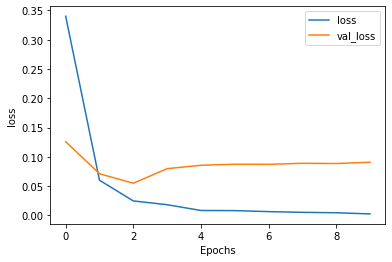

In [22]:
model_2 = model_ConvLstm(vocab_size, embedding_dim, max_length)
model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_2.summary()

tf.keras.backend.clear_session()
history_2 = model_2.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_validation, y_validation), verbose=2)
print("Model 2 Training Complete")

plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

# Model Evaluation

Those two models both perform pretty well. <br>
For model_1, the loss on validation shows a upward trend, it may indicate model_1 is overfitting. model_2 faces a similar issue in the end.<br>
We choose model_1 this time to see its ability to generalize on test set. 

In [23]:
loss, acc = model_1.evaluate(X_test, y_test)
print(loss, acc)

27/27 [==============================] - 0s 15ms/step - loss: 0.0919 - accuracy: 0.9844
0.09186752885580063 0.9844497442245483


In [24]:
def decode_sentence(index_word, text):
  """
    Convert the sentense from index to words
    
    Arguments:
    index_word -- dictionary with key as the index and word as value, i.e. {1:'good'}
    text -- the sequence represents a sentense of words
  """
  return ' '.join([index_word.get(i, '') for i in text])

In [25]:
def plot_confusion_matrix(actual_label, predicted_label):
  """
    Plot the confusion matrix
    
    Arguments:
    acutal_label -- the acutal label of the data
    predicted_label -- labes predicted by the model
  """
  cm = tf.math.confusion_matrix(actual_label,predicted_label) 
  plt.figure(figsize = (5,5))
  sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Ham','Spam'] , yticklabels = ['Ham','Spam'])


In [26]:
pred_1 = model_1.predict(np.expand_dims(X_test[66], axis = 0))
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print(decode_sentence(reverse_word_index, X_test[66]))
print("Acutall Label: {}".format('spam' if y_test[66]==1 else 'ham'))
print("Predicted Label: {}".format('spam' if np.squeeze(pred_1[0])>0.5 else 'ham'))

sir waiting mail                                                                                                 
Acutall Label: ham
Predicted Label: ham


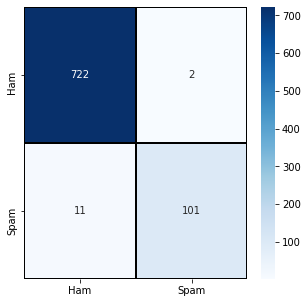

In [27]:
pred_labels = (model_1.predict(X_test) > 0.5).astype("int32")
plot_confusion_matrix(y_test, pred_labels)

Let's take a look which text the model has classified wrongly.

In [28]:
def check_misclassification(X, y, predictions, index_word):
  """
    Print the text that have been misclassified
    
    Arguments:
    X -- text collection
    y -- acutal labels
    predictions -- predicted labels
    index_word -- dictionary that used to convert index to word
  """
  pred = np.copy(predictions)
  pred = np.reshape(pred, (pred.shape[0],))
  index = np.where(np.not_equal(y, pred))[0]

  for id in index:
    seq = X[id]
    text = decode_sentence(index_word, seq).strip()
    print("{} | Actual: {} | Predicted: {}".format(text, y[id], str(predictions[id]).lstrip('[').rstrip(']')))

In [29]:
check_misclassification(X_test, y_test, pred_labels, reverse_word_index)

believe true incredible txts reply g learn truly amazing things blow mind o2fwd 18p txt | Actual: 1 | Predicted: 0
jade paul didnåõt txt remember barmed want 2 talk 2 txt | Actual: 0 | Predicted: 1
sms ac sun 0819 posts hello seem cool | Actual: 1 | Predicted: 0
simpsons movie released july 2007 name band died start film a green day b blue day c red day send b c | Actual: 1 | Predicted: 0
message text missing sender name missing number missing sent d ate missing missing lot thats everything missing sent via fullonsms com | Actual: 0 | Predicted: 1
xclusive clubsaisai 2morow 28 5 soiree speciale zouk nichols paris free roses 2 ladies info 07946746291 07880867867 | Actual: 1 | Predicted: 0
welcome please reply age gender begin e g 24m | Actual: 1 | Predicted: 0
filthy stories girls waiting | Actual: 1 | Predicted: 0
dating two started sent text talk sport radio last week connection think coincidence | Actual: 1 | Predicted: 0
latest news police station toilet stolen cops nothing go | Act

# Discussion


There are two practices to build the vocabulary. In above experiment, we used all the text in the whole dataset to build the vocabulary. Another way is only using text in the train set. There is a discussion on [StackOverflow](https://stackoverflow.com/questions/54891464/is-it-better-to-keras-fit-to-text-on-the-entire-x-data-or-just-the-train-data) about this topic you could refer to. <br>
Validation set and test set represent data the model has never seen, by intuition, only using training text to build the vocabulary could be more objective to evaluate the model's performance. 
 let's see how the model goes if we build the vocabulary only with train text.


In [30]:
vocab_size_2 = 10000

(X_train_2, y_train_2, X_validation_2, y_validation_2, X_test_2, y_test_2, word_index_2) = \
  tokenize(train, validation, test, vocab_size_2, oov_tok, 'train', 'cleaned_text', 'label')

In [31]:
vocab_size_2 = len(word_index_2)
print("The acutal vocabulary size: {}".format(vocab_size_2))
print(len(X_train_2), len(y_train_2))
print(len(X_validation_2), len(y_validation_2))
print(len(X_test_2), len(y_test_2))
print(X_train_2[1:3])

The acutal vocabulary size: 7124
3900 3900
836 836
836 836
[[ 155 3370 3371 3372 2222 3373   53  527 3374 2223  282  118   99 1174
  3375  390   31 1033 1034  913    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  12  115   12 2224    2 3376   97  212  171 3377   87    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

The vocabulary size is 7124, compared with the vocabulary size we got from the whole dataset 8705, there is a 1581 difference. Let's see how the model goes with the new vocabulary.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          712500    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 805,301
Trainable params: 805,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
122/122 - 7s - loss: 0.1806 - accuracy: 0.9410 - val_loss: 0.0526 - val_accuracy: 0.9833
Epoch 2/10
122/122 - 6s - loss: 0.0192 - accuracy: 0.9946 - val_loss: 0.0502 - val_accuracy: 0.9844
Epoch 3/10
122/122 - 6s - loss: 0.0054 - accurac

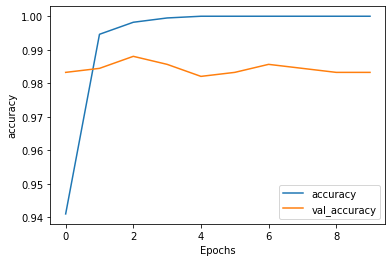

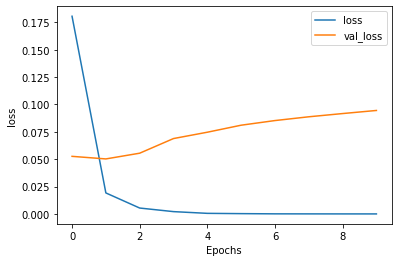

In [32]:
model_3 = model_biLstm(vocab_size_2, embedding_dim, max_length)
model_3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_3.summary()

tf.keras.backend.clear_session()

history_3 = model_3.fit(X_train_2, y_train_2, epochs=num_epochs, validation_data=(X_validation_2, y_validation_2), verbose=2)
print("Model 3 Training Complete")

plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

In [33]:
loss_2, acc_2 = model_3.evaluate(X_test_2, y_test_2)
print(loss_2, acc_2)

27/27 [==============================] - 0s 16ms/step - loss: 0.0980 - accuracy: 0.9844
0.0979703962802887 0.9844497442245483


In [34]:
pred_2 = model_3.predict(np.expand_dims(X_test_2[66], axis = 0))
reverse_word_index_2 = dict([(value, key) for (key, value) in word_index_2.items()])
text = decode_sentence(reverse_word_index_2, X_test_2[66])
print(text)
print("Acutall Label: {}".format('spam' if y_test_2[66]==1 else 'ham'))
print("Predicted Label: {}".format('spam' if np.squeeze(pred_2[0])>0.5 else 'ham'))

sir waiting mail                                                                                                 
Acutall Label: ham
Predicted Label: ham


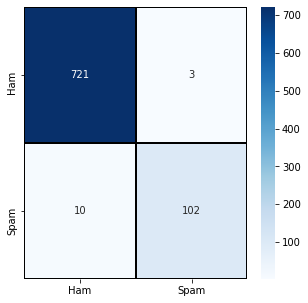

In [35]:
pred_labels_2 = (model_3.predict(X_test_2) > 0.5).astype("int32")
plot_confusion_matrix(y_test_2, pred_labels_2)

In [36]:
check_misclassification(X_test_2, y_test_2, pred_labels_2, reverse_word_index_2)

believe true <OOV> txts reply g learn truly amazing things blow mind <OOV> <OOV> txt | Actual: 1 | Predicted: 0
<OOV> <OOV> didnåõt txt remember <OOV> want 2 talk 2 txt | Actual: 0 | Predicted: 1
sms ac sun <OOV> <OOV> hello seem cool | Actual: 1 | Predicted: 0
<OOV> movie released july 2007 name <OOV> died start film a green day b blue day c red day send b c | Actual: 1 | Predicted: 0
welcome please reply age <OOV> begin e g <OOV> | Actual: 1 | Predicted: 0
<OOV> <OOV> girls waiting | Actual: 1 | Predicted: 0
dating two started sent text talk sport radio last week connection think <OOV> | Actual: 1 | Predicted: 0
latest news police station <OOV> <OOV> <OOV> nothing go | Actual: 1 | Predicted: 0
<OOV> <OOV> chasing us since sept <OOV> £ <OOV> definitely paying thanks information ignore <OOV> <OOV> | Actual: 1 | Predicted: 0
message brought <OOV> ltd <OOV> | Actual: 1 | Predicted: 0
<OOV> msg na <OOV> <OOV> <OOV> 7 name 1 <OOV> 2 <OOV> 3 <OOV> 4 <OOV> 5 <OOV> 6 <OOV> 7 <OOV> <OOV> 7 nam

Regarding the different practices to build vocabulary with whole dataset or only with train set, the model performance in this case did not show a significant difference.<br>

One of the differences caused by these two practices is wordembedding. Let's make a symbolic distinguish first: <br>

*   all_vocabulary: vocabulary built with all text in the whole dataset
*   all_embedding: embedding with all_vocabulary size
*   train_vocabulary: vocabulary built only with train text
*   train_embedding: embedding with train_vocabulary size


Compared with train_embedding, all_embedding will hold 1581 more words, and all those 1581 words in train_embedding will be represented as unknown word `<OOV>`. As [Jay](http://jalammar.github.io/illustrated-word2vec/) suggests, before training wordembedding, each word vector in the embedding matrix will be instialized with random numbers. And train text will be resampled into (target, context) as training examples and the learning algorithm will use those newly generated examples to update each word vector in the embedding. In this case, since 1581 words are not in the train text, training examples will not be generated for those words by taking them as target. Thus, the vectors of those words in the all_embedding might not be well updated. Since we included all the words in the vocabulary, the unknown word representation `<OOV>` could face a similar situation.

One reason that this case did not show model performance difference could be our dataset is relatively small and we include most of the words in our vocabularies, thus, the words that contribute to the classification are included in both vocabularies and their word vectors in wordembedding are effectively learned.

# Summary
1. When start working on your datasets, it could be a good idea to look for recently published or shared NN architectures, hyper parameters to try on your dataset. In this case, it worked pretty well and could save a lot of time.
2. Split data into train, validation, and test set is a good practice to build models, even though we did not use validtion set to tune our models in this case.
3. This case does not show the evidence that building the vocabulary on the whole dataset could bring bias into the model. This could be due to we include most words into the vocabulary.

# References:
1. https://www.tensorflow.org/tutorials/text/text_classification_rnn
2. https://keras.io/examples/nlp/pretrained_word_embeddings/
3. https://www.coursera.org/learn/machine-learning/lecture/QGKbr/model-selection-and-train-validation-test-sets
4. https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/NFvFd/going-back-to-the-imdb-dataset
5. http://jalammar.github.io/illustrated-word2vec/